# Random Forest Augmentation

In this example, we will run the Fortran model with a bias corrector scheme implemented as a random forest which is called at the end of each timestep. We'll interactively look at the model state in the middle of execution, to try to understand a bit about the behavior of the bias corrector. This is a proof-of-concept example - the random forest scheme is not necessarily performant or even stable over many time steps. The purpose is to demonstrate the interactive execution of the Fortran model in a Jupyter notebook.

This example requires ipyparallel configured with MPI in order to run. We have given an example which provides this environment using Docker in examples/jupyter.

To run the Fortran model, we need to be working in a run directory. Let's download one we've prepared for this example.

In [1]:
%%bash
wget https://storage.googleapis.com/vcm-ml-public/ams2021/c48_1_day.tar.gz

--2020-12-17 23:58:09--  https://storage.googleapis.com/vcm-ml-public/ams2021/c48_1_day.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 199429186 (190M) [application/x-tar]
Saving to: ‘c48_1_day.tar.gz’

     0K .......... .......... .......... .......... ..........  0% 1.48M 2m8s
    50K .......... .......... .......... .......... ..........  0% 1.77M 1m58s
   100K .......... .......... .......... .......... ..........  0% 2.14M 1m48s
   150K .......... .......... .......... .......... ..........  0% 2.12M 1m43s
   200K .......... .......... .......... .......... ..........  0% 2.12M 1m41s
   250K .......... .......... .......... .......... ..........  0% 2.12M 99s
   300K .......... .......... .......... .......... ..........  0% 2.09M 98s
   350K .......... ........

In [2]:
%%bash
tar -zxvf c48_1_day.tar.gz
mv rundir rundir_c48

rundir/
rundir/aerosol.dat
rundir/._.DS_Store
rundir/.DS_Store
rundir/sfc_emissivity_idx.txt
rundir/diag_table
rundir/INPUT/
rundir/co2historicaldata_2016.txt
rundir/co2historicaldata_2015.txt
rundir/grb/
rundir/co2historicaldata_2014.txt
rundir/co2historicaldata_2010.txt
rundir/co2historicaldata_2011.txt
rundir/co2historicaldata_2013.txt
rundir/RESTART/
rundir/co2historicaldata_2012.txt
rundir/README.md
rundir/data_table
rundir/fv3.exe
rundir/solarconstant_noaa_an.txt
rundir/fv3config.yml
rundir/field_table
rundir/input.nml
rundir/global_o3prdlos.f77
rundir/grb/global_snoclim.1.875.grb
rundir/grb/RTGSST.1982.2012.monthly.clim.grb
rundir/grb/global_maxice.2x2.grb
rundir/grb/global_albedo4.1x1.grb
rundir/grb/global_glacier.2x2.grb
rundir/grb/seaice_newland.grb
rundir/grb/global_soilmgldas.t1534.3072.1536.grb
rundir/grb/CFSR.SEAICE.1982.2012.monthly.clim.grb
rundir/grb/global_snowfree_albedo.bosu.t1534.3072.1536.rg.grb
rundir/grb/global_vegfrac.0.144.decpercent.grb
rundir/grb/global_shdm

This cell will start the MPI cluster used after we run %autopx. Do not be alarmed by the red text output, this is triggered by the --debug flag. Using this flag will provide us with extra logging information in the case of a crash. If you do get a crash or hang, refer to the last section of this notebook which provides some tools for debugging.

In [3]:
%%bash
# if you get a crash, add --debug to this command to put more info in logs
# logs are in /root/.ipython/profile_mpi/log
ipcluster start --profile=mpi -n 6 --daemonize --debug
sleep 10  # command is asynchronous, so let's wait to avoid an error in the next cell

2020-12-17 23:59:17.094 [IPClusterStart] IPYTHONDIR set to: /root/.ipython
2020-12-17 23:59:17.096 [IPClusterStart] Using existing profile dir: '/root/.ipython/profile_mpi'
2020-12-17 23:59:17.096 [IPClusterStart] Searching path ['/notebooks', '/root/.ipython/profile_mpi', '/usr/etc/ipython', '/usr/local/etc/ipython', '/etc/ipython'] for config files
2020-12-17 23:59:17.097 [IPClusterStart] Attempting to load config file: ipython_config.py
2020-12-17 23:59:17.097 [IPClusterStart] Looking for ipython_config in /etc/ipython
2020-12-17 23:59:17.097 [IPClusterStart] Looking for ipython_config in /usr/local/etc/ipython
2020-12-17 23:59:17.097 [IPClusterStart] Looking for ipython_config in /usr/etc/ipython
2020-12-17 23:59:17.097 [IPClusterStart] Looking for ipython_config in /root/.ipython/profile_mpi
2020-12-17 23:59:17.098 [IPClusterStart] Loaded config file: /root/.ipython/profile_mpi/ipython_config.py
2020-12-17 23:59:17.098 [IPClusterStart] Looking for ipython_config in /notebooks
2020

Next we configure the notebook to use this cluster.

In [4]:
import ipyparallel as ipp
rc = ipp.Client(profile='mpi', targets='all', block=True)
dv = rc[:]
dv.activate()
dv.block = True

In [5]:
print("Running IPython Parallel on {0} MPI engines".format(len(rc.ids)))
print("Commands in the following cells will be executed in parallel (disable with %autopx)")
%autopx

Running IPython Parallel on 6 MPI engines
Commands in the following cells will be executed in parallel (disable with %autopx)
%autopx enabled


We can confirm that we're running in parallel using mpi4py.

In [6]:
from mpi4py import MPI

comm = MPI.COMM_WORLD
mpi_size = comm.Get_size()
mpi_rank = comm.Get_rank()

print(f"Number of ranks is {mpi_size}.")
print(f"I am rank {mpi_rank}.")

[stdout:0] 
Number of ranks is 6.
I am rank 0.
[stdout:1] 
Number of ranks is 6.
I am rank 1.
[stdout:2] 
Number of ranks is 6.
I am rank 2.
[stdout:3] 
Number of ranks is 6.
I am rank 3.
[stdout:4] 
Number of ranks is 6.
I am rank 4.
[stdout:5] 
Number of ranks is 6.
I am rank 5.


Next we move into the run directory.

In [7]:
import os

In [8]:
os.chdir("rundir_c48")
os.listdir(".")

Out[0:3]: 
['.DS_Store',
 '._.DS_Store',
 'INPUT',
 'README.md',
 'RESTART',
 'aerosol.dat',
 'co2historicaldata_2010.txt',
 'co2historicaldata_2011.txt',
 'co2historicaldata_2012.txt',
 'co2historicaldata_2013.txt',
 'co2historicaldata_2014.txt',
 'co2historicaldata_2015.txt',
 'co2historicaldata_2016.txt',
 'data_table',
 'diag_table',
 'field_table',
 'fv3.exe',
 'fv3config.yml',
 'global_o3prdlos.f77',
 'grb',
 'input.nml',
 'sfc_emissivity_idx.txt',
 'solarconstant_noaa_an.txt']

Out[1:3]: 
['.DS_Store',
 '._.DS_Store',
 'INPUT',
 'README.md',
 'RESTART',
 'aerosol.dat',
 'co2historicaldata_2010.txt',
 'co2historicaldata_2011.txt',
 'co2historicaldata_2012.txt',
 'co2historicaldata_2013.txt',
 'co2historicaldata_2014.txt',
 'co2historicaldata_2015.txt',
 'co2historicaldata_2016.txt',
 'data_table',
 'diag_table',
 'field_table',
 'fv3.exe',
 'fv3config.yml',
 'global_o3prdlos.f77',
 'grb',
 'input.nml',
 'sfc_emissivity_idx.txt',
 'solarconstant_noaa_an.txt']

Out[2:3]: 
['.DS_Store',
 '._.DS_Store',
 'INPUT',
 'README.md',
 'RESTART',
 'aerosol.dat',
 'co2historicaldata_2010.txt',
 'co2historicaldata_2011.txt',
 'co2historicaldata_2012.txt',
 'co2historicaldata_2013.txt',
 'co2historicaldata_2014.txt',
 'co2historicaldata_2015.txt',
 'co2historicaldata_2016.txt',
 'data_table',
 'diag_table',
 'field_table',
 'fv3.exe',
 'fv3config.yml',
 'global_o3prdlos.f77',
 'grb',
 'input.nml',
 'sfc_emissivity_idx.txt',
 'solarconstant_noaa_an.txt']

Out[3:3]: 
['.DS_Store',
 '._.DS_Store',
 'INPUT',
 'README.md',
 'RESTART',
 'aerosol.dat',
 'co2historicaldata_2010.txt',
 'co2historicaldata_2011.txt',
 'co2historicaldata_2012.txt',
 'co2historicaldata_2013.txt',
 'co2historicaldata_2014.txt',
 'co2historicaldata_2015.txt',
 'co2historicaldata_2016.txt',
 'data_table',
 'diag_table',
 'field_table',
 'fv3.exe',
 'fv3config.yml',
 'global_o3prdlos.f77',
 'grb',
 'input.nml',
 'sfc_emissivity_idx.txt',
 'solarconstant_noaa_an.txt']

Out[4:3]: 
['.DS_Store',
 '._.DS_Store',
 'INPUT',
 'README.md',
 'RESTART',
 'aerosol.dat',
 'co2historicaldata_2010.txt',
 'co2historicaldata_2011.txt',
 'co2historicaldata_2012.txt',
 'co2historicaldata_2013.txt',
 'co2historicaldata_2014.txt',
 'co2historicaldata_2015.txt',
 'co2historicaldata_2016.txt',
 'data_table',
 'diag_table',
 'field_table',
 'fv3.exe',
 'fv3config.yml',
 'global_o3prdlos.f77',
 'grb',
 'input.nml',
 'sfc_emissivity_idx.txt',
 'solarconstant_noaa_an.txt']

Out[5:3]: 
['.DS_Store',
 '._.DS_Store',
 'INPUT',
 'README.md',
 'RESTART',
 'aerosol.dat',
 'co2historicaldata_2010.txt',
 'co2historicaldata_2011.txt',
 'co2historicaldata_2012.txt',
 'co2historicaldata_2013.txt',
 'co2historicaldata_2014.txt',
 'co2historicaldata_2015.txt',
 'co2historicaldata_2016.txt',
 'data_table',
 'diag_table',
 'field_table',
 'fv3.exe',
 'fv3config.yml',
 'global_o3prdlos.f77',
 'grb',
 'input.nml',
 'sfc_emissivity_idx.txt',
 'solarconstant_noaa_an.txt']

The stage is set. We're running in parallel using MPI, and we're in a run directory. Now we can start running the model! First we will import the packages used in the rest of the example.

In [9]:
import fv3gfs.wrapper
from fv3gfs.util import (
    TilePartitioner, CubedSpherePartitioner, CubedSphereCommunicator, Quantity,
    X_DIM, Y_DIM, Z_DIM, X_INTERFACE_DIM, Y_INTERFACE_DIM
)
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import f90nml
from datetime import timedelta

In [10]:
namelist = f90nml.read("input.nml")
layout = namelist["fv_core_nml"]["layout"]
timestep = timedelta(seconds=namelist["coupler_nml"]["dt_atmos"])
cube = CubedSphereCommunicator(
    MPI.COMM_WORLD,
    CubedSpherePartitioner(
        TilePartitioner(layout)
    ),
)

In [11]:
def get_X_Y(shape):
    """Get coordinate locations for plotting a global field as a flattened cube."""
    X = np.zeros([shape[0], shape[1] + 1, shape[2] + 1]) + np.arange(0, shape[1] + 1)[None, :, None]
    Y = np.zeros([shape[0], shape[1] + 1, shape[2] + 1]) + np.arange(0, shape[2] + 1)[None, None, :]
    # offset and rotate the data for each rank, with zero at the "center"
    for tile, shift_x, shift_y, n_rotations in [
        (1, 1, 0, 0), (2, 0, 1, -1), (3, 2, 0, 1), (4, -1, 0, 1), (5, 0, -1, 0)
    ]:
        X[tile, :, :] += shift_x * shape[1]
        Y[tile, :, :] += shift_y * shape[2]
        X[tile, :, :] = np.rot90(X[tile, :, :], n_rotations)
        Y[tile, :, :] = np.rot90(Y[tile, :, :], n_rotations)
    return X, Y

def plot_global(quantity, cube, vmin, vmax):
    """Plot a quantity globally on the root rank as a flattened cube."""
    assert quantity.dims == (Y_DIM, X_DIM), "example written to plot 2D fields"
    global_quantity = cube.gather(quantity)
    if global_quantity is not None:  # only on first rank
        X, Y = get_X_Y(global_quantity.extent)
        plt.figure(figsize=(9, 5.5))
        for tile in range(global_quantity.extent[0]):
            im = plt.pcolormesh(
                X[tile, :, :],
                Y[tile, :, :],
                global_quantity.view[tile, :, :].T,
                vmin=vmin,
                vmax=vmax,
        )
        plt.colorbar(im)
        # we don't plt.show() here in case you want to run more commands after plot_global

In [12]:
# These commands would reproduce a full run of the base Fortran model.
# They're included here as a comment for reference.

# fv3gfs.wrapper.initialize()
# for i in range(fv3gfs.wrapper.get_step_count()):
#     fv3gfs.wrapper.step_dynamics()
#     fv3gfs.wrapper.step_physics()
#     fv3gfs.wrapper.save_intermediate_restart_if_enabled()
# fv3gfs.wrapper.cleanup()

In [13]:
rf_model = fv3gfs.wrapper.examples.get_random_forest()
fv3gfs.wrapper.initialize()

We can confirm our MPI communication and plotting code is working correctly by plotting surface pressure, which is a reasonable proxy for surface height.

[output:0]

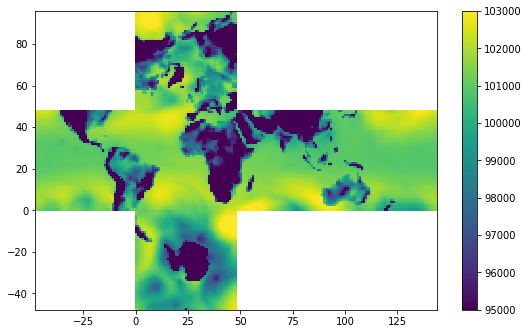

In [14]:
plot_global(
    fv3gfs.wrapper.get_state(["surface_pressure"])["surface_pressure"],
    cube,
    vmin=95e3,
    vmax=103e3
)

When we run this model with our machine learning augmentation, we get significant drying of the atmosphere. We want to diagnose why, and better understand the issue. To quickly look at global structure of mosture, let's define column total water.

In [15]:
def column_total_water(specific_humidity, pressure_thickness):
    assert specific_humidity.dims == (Z_DIM, Y_DIM, X_DIM)
    assert specific_humidity.units == "kg/kg", specific_humidity.units
    assert pressure_thickness.dims == (Z_DIM, Y_DIM, X_DIM)
    assert pressure_thickness.units == "Pa", pressure_thickness.units
    mass = pressure_thickness.view[:] * 9.81
    total_water = np.sum(mass * specific_humidity.view[:], axis=0)
    return Quantity(
        total_water,
        dims=(Y_DIM, X_DIM),
        units="kg"
    )

First we'll look in detail at the first time step. Let's see how much of the first step moisture tendency is due to dynamics, physics, and our machine learning.

In [16]:
names = ("specific_humidity", "pressure_thickness_of_atmospheric_layer")
state_initial = fv3gfs.wrapper.get_state(names)
total_water_initial = column_total_water(
    state_initial["specific_humidity"],
    state_initial["pressure_thickness_of_atmospheric_layer"]
)

In [17]:
print(total_water_initial.view[:].min(), total_water_initial.view[:].max())

[stdout:0] 144.68085593556557 5829.071030845843
[stdout:1] 276.122941015188 7295.380620713697
[stdout:2] 191.92647805246835 5535.159344597077
[stdout:3] 480.22442530890925 6018.810315724958
[stdout:4] 97.72989657442665 6190.269996096998
[stdout:5] 10.752861394795428 3130.1053123092424


[output:0]

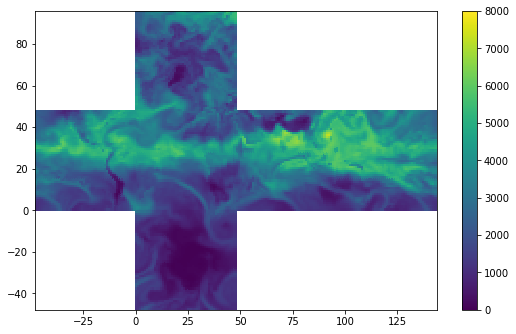

In [18]:
plot_global(total_water_initial, cube, vmin=0, vmax=8000)

In [19]:
fv3gfs.wrapper.step_dynamics()
state_after_dynamics = fv3gfs.wrapper.get_state(names)
total_water_after_dynamics = column_total_water(
    state_after_dynamics["specific_humidity"],
    state_after_dynamics["pressure_thickness_of_atmospheric_layer"]
)

In [20]:
fv3gfs.wrapper.step_physics()
fv3gfs.wrapper.save_intermediate_restart_if_enabled()
state_after_physics = fv3gfs.wrapper.get_state(names)
total_water_after_physics = column_total_water(
    state_after_physics["specific_humidity"],
    state_after_physics["pressure_thickness_of_atmospheric_layer"]
)

In [21]:
state = fv3gfs.wrapper.get_state(rf_model.inputs)
rf_model.update(state, timestep=timestep)
fv3gfs.wrapper.set_state_mass_conserving(state)
state_after_rf = fv3gfs.wrapper.get_state(names)
total_water_after_rf = column_total_water(
    state_after_rf["specific_humidity"],
    state_after_rf["pressure_thickness_of_atmospheric_layer"]
)

Because Quantity hopes to make your life easier in the long term by being strict about units, it doesn't currently have arithmetic routines implemented. Let's make some simple ones which are good enough for our purposes here.

In [22]:
def subtract(q1, q2):
    assert q1.units == q2.units
    data_array = q1.data_array - q2.data_array
    data_array.attrs["units"] = q1.units
    return Quantity.from_data_array(data_array)

def multiply(q1, q2):
    # this will eventually be implemented for Quantity as a units-aware calculation
    data_array = q1.data_array * q2.data_array
    data_array.attrs["units"] = "unknown"
    return Quantity.from_data_array(data_array)

[output:0]

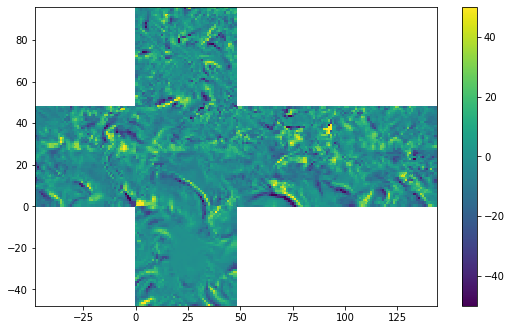

In [23]:
plot_global(
    subtract(total_water_after_dynamics, total_water_initial),
    cube,
    vmin=-50,
    vmax=50
)

[output:0]

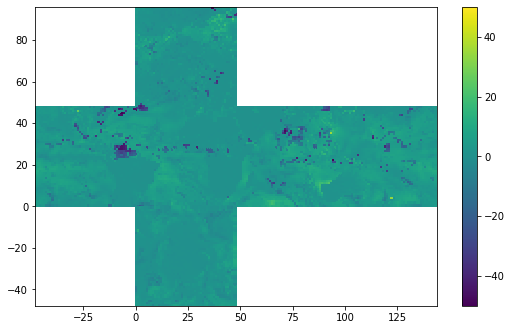

In [24]:
plot_global(
    subtract(total_water_after_physics, total_water_after_dynamics),
    cube,
    vmin=-50,
    vmax=50
)

[output:0]

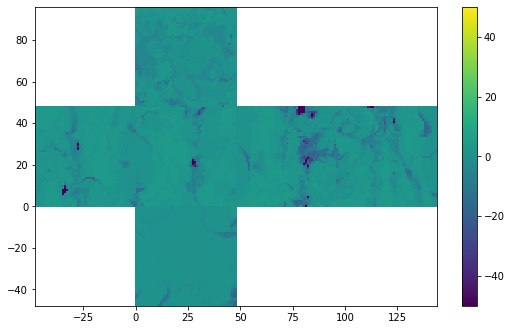

In [25]:
plot_global(
    subtract(total_water_after_rf, total_water_after_physics),
    cube,
    vmin=-50,
    vmax=50
)

The correction from the random forest doesn't even appear at the same scale as we used for the dynamics and physics. Because we're running interactively, we can inspect its values to determine an appropriate plotting range.

We can see the random forest corrector is mainly drying out the atmosphere. It isn't immediately obvious why it's choosing to dry out certain areas. Personally, I'm curious about whether the drying is happening mostly in regions where the physics is drying or moistening the atmosphere. For areas where the random forest is doing anything, let's plot whether the signs agree.

In [26]:
rf_update = subtract(total_water_after_rf, total_water_after_physics)
result = multiply(
    rf_update,
    subtract(total_water_after_physics, total_water_after_dynamics)
)
result.view[:] = np.sign(result.view[:])
result.view[:][np.abs(rf_update.view[:]) < 5] = 0.  # 5 chosen by testing different numbers
print(result.view[:].min(), result.view[:].max())

[stdout:0] -1.0 1.0
[stdout:1] -1.0 1.0
[stdout:2] -1.0 1.0
[stdout:3] -1.0 1.0
[stdout:4] -1.0 1.0
[stdout:5] -1.0 1.0


[output:0]

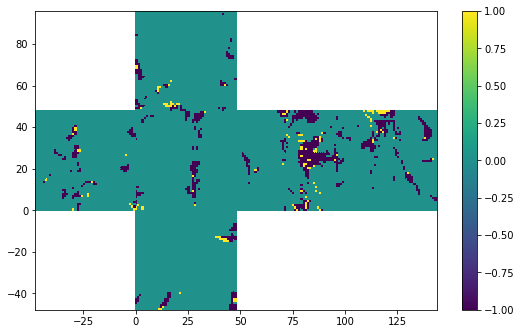

In [27]:
plot_global(result, cube, vmin=-1, vmax=1)

The first thing this tells us the random forest is mostly precipitating in regions where the physics is moistening the column. Look more closely at the blob in region x: (75, 100) and y: (20:40). If we look back at the plot of the physics update, we can see the sharp yellow areas where the physics and random forest agree on sign are grid-scale precipitation. In this region, the random forest appears to indicate the physics parameterization is under-precipitating. We can confirm this by looking at a vertical column from this region, and seeing if the drying tendency from the random forest looks like precipitation.

I can't remember the orientation and placement of the ranks, so let's plot them.

[output:0]

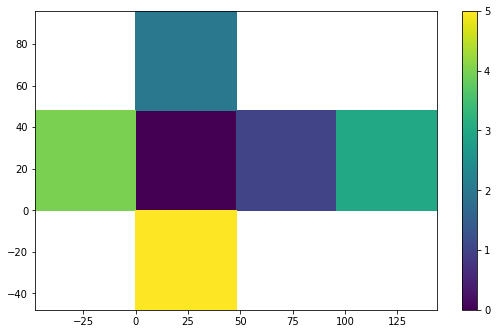

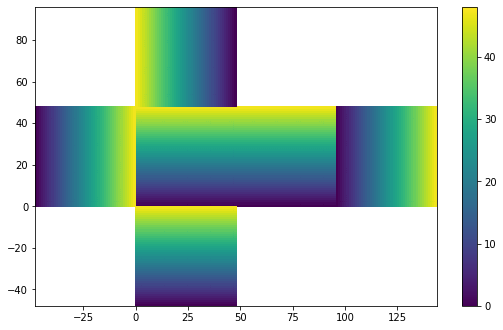

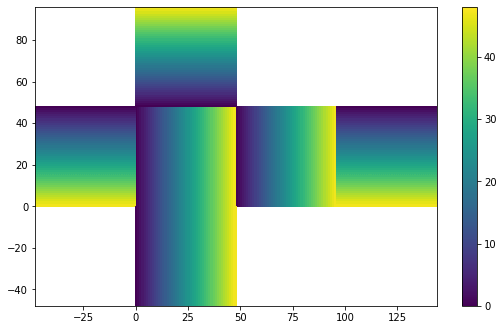

In [28]:
import copy
quantity = copy.deepcopy(result)
quantity.view[:] = cube.rank
plot_global(quantity, cube, vmin=0, vmax=5)
quantity.view[:, :] = np.arange(quantity.extent[0])[:, None]
plot_global(quantity, cube, vmin=0, vmax=quantity.extent[0])
quantity.view[:, :] = np.arange(quantity.extent[1])[None, :]
plot_global(quantity, cube, vmin=0, vmax=quantity.extent[1])

It appears we want to inspect rank 1, whose first axis increases along x and second axis increases along y in the plot. We can use this information to ballpark the region we want to be looking at, and make a new plot to confirm we've selected the right index.

[output:0]

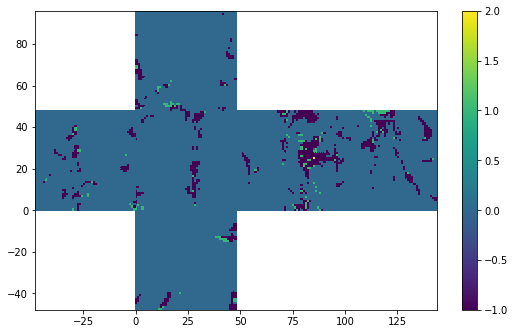

In [29]:
ix = 85 - 48  # rank 1's area starts at x=48
iy = 25

# result is the -1/0/1 plot from earlier for sign agreement
quantity = copy.deepcopy(result)
if cube.rank == 1:
    quantity.view[iy, ix] = 2
plot_global(quantity, cube, vmin=-1, vmax=2)

Great, our index is well within the region where the random forest is lightly precipitating and the physics is not. Let's take a look at the vertical profile.

[output:1]

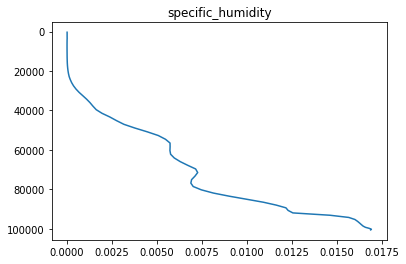

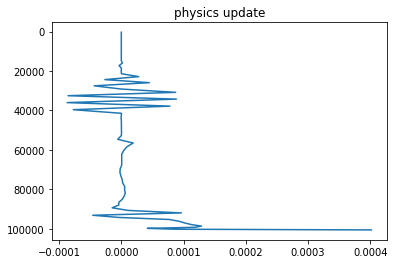

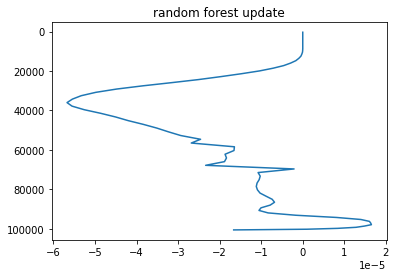

In [30]:
if cube.rank == 1:
    p = np.cumsum(state["pressure_thickness_of_atmospheric_layer"].view[:, iy, ix], axis=0)
    physics_update = subtract(
        state_after_physics["specific_humidity"],
        state_after_dynamics["specific_humidity"]
    )
    rf_update = subtract(
        state_after_rf["specific_humidity"],
        state_after_physics["specific_humidity"]
    )
    plt.figure()
    plt.plot(state_after_dynamics["specific_humidity"].view[:, iy, ix], p)
    plt.gca().invert_yaxis()
    plt.title("specific_humidity")
    plt.figure()
    plt.plot(physics_update.view[:, iy, ix], p)
    plt.gca().invert_yaxis()
    plt.title("physics update")
    plt.figure()
    plt.plot(rf_update.view[:, iy, ix], p)
    plt.gca().invert_yaxis()
    plt.title("random forest update")
    

These plots tell us that we cannot reasonably call what the random forest is doing in this case "precipitation". The drying is happening broadly throughout the troposphere, and is not particularly concentrated where there is humidity or where the physics routines are precipitating (at and below 800 hPa).

The strong negative humidity tendencies in the uppper troposphere are concerning, given the model does not have very much moisture at these levels. It's likely to cause negative humidity. Let's evolve the model a few hours, and see if the drying lessens or stops. Uncomment the line setting total_timesteps to do this (it is set to zero by default for testing this notebook). This may take a few minutes.

In [31]:
seconds_in_hour = 60*60
timesteps_in_hour = seconds_in_hour / timestep.total_seconds()
total_timesteps = 0
#total_timesteps = int(3 * timesteps_in_hour)
print(total_timesteps)

[stdout:0] 0
[stdout:1] 0
[stdout:2] 0
[stdout:3] 0
[stdout:4] 0
[stdout:5] 0


In [32]:
for i in range(total_timesteps):
    fv3gfs.wrapper.step()
    state = fv3gfs.wrapper.get_state(rf_model.inputs)
    rf_model.update(state, timestep=timestep)
    fv3gfs.wrapper.set_state_mass_conserving(state)

In [33]:
fv3gfs.wrapper.step_dynamics()
state_after_dynamics = fv3gfs.wrapper.get_state(names)
total_water_after_dynamics = column_total_water(
    state_after_dynamics["specific_humidity"],
    state_after_dynamics["pressure_thickness_of_atmospheric_layer"]
)

In [34]:
fv3gfs.wrapper.step_physics()
fv3gfs.wrapper.save_intermediate_restart_if_enabled()
state_after_physics = fv3gfs.wrapper.get_state(names)
total_water_after_physics = column_total_water(
    state_after_physics["specific_humidity"],
    state_after_physics["pressure_thickness_of_atmospheric_layer"]
)

In [35]:
state = fv3gfs.wrapper.get_state(rf_model.inputs)
rf_model.update(state, timestep=timestep)
fv3gfs.wrapper.set_state_mass_conserving(state)
state_after_rf = fv3gfs.wrapper.get_state(names)
total_water_after_rf = column_total_water(
    state_after_rf["specific_humidity"],
    state_after_rf["pressure_thickness_of_atmospheric_layer"]
)

[output:1]

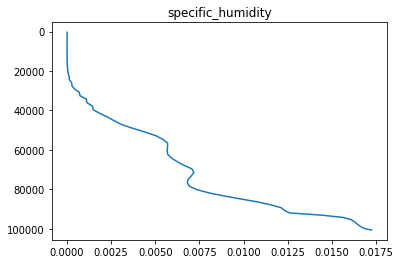

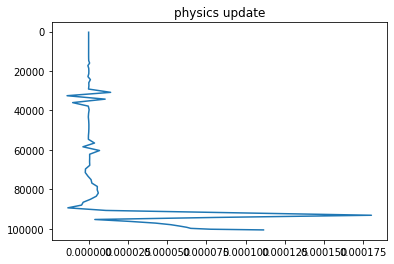

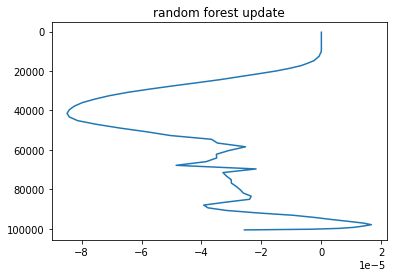

In [36]:
if cube.rank == 1:
    p = np.cumsum(state["pressure_thickness_of_atmospheric_layer"].view[:, iy, ix], axis=0)
    physics_update = subtract(
        state_after_physics["specific_humidity"],
        state_after_dynamics["specific_humidity"]
    )
    rf_update = subtract(
        state_after_rf["specific_humidity"],
        state_after_physics["specific_humidity"]
    )
    plt.figure()
    plt.plot(state_after_dynamics["specific_humidity"].view[:, iy, ix], p)
    plt.gca().invert_yaxis()
    plt.title("specific_humidity")
    plt.figure()
    plt.plot(physics_update.view[:, iy, ix], p)
    plt.gca().invert_yaxis()
    plt.title("physics update")
    plt.figure()
    plt.plot(rf_update.view[:, iy, ix], p)
    plt.gca().invert_yaxis()
    plt.title("random forest update")
    

It's encouraging that we see the negative tendencies in the upper troposphere lessen. There's an interesting peak around 700 hPa which seems to be getting strengthened by the random forest. In an interactive notebook, we could continue our analysis by saving fields over the next few hours and producing an animation.

This notebook could go on forever, but we'll stop here. Hopefully this has shown the strength of being able to use interactive execution of a Fortran model to diagnose model behavior. This is not limited to investigating machine learning parameterizations, or even Python parameterizations. A researcher could augment an existing Fortran model with new Fortran code also wrapped to be accessible from Python, and use interactive execution to diagnose issues with their scheme.

While not strictly necessary, let's run the Fortran cleanup routines to deallocate memory and write any final restart or diagnostic files.

In [37]:
fv3gfs.wrapper.cleanup()

## Debugging tools

If you get a deadlock or hang for another reason (even Python exceptions can cause this sometimes), you will need to look at the ipyparallel log file to see what went wrong.

Use these cells to shut down the cluster if needed, for example to restart in the case of deadlocks.

Make sure you are running on the notebook process (instead of the cluster processes) by running %autopx until it says it is disabled.

In [ ]:
%autopx

In [ ]:
rc.shutdown(hub=True)

In [ ]:
%%bash
ipcluster stop --profile=mpi

These cells list the files in the log directory, and print the first file (in effect a random file). This is useful if you get a crash quickly and only one log file is present. Otherwise, modify the command or write a `%%bash` cell to print the log files you would like to read.

In [ ]:
import os

log_dir = "/root/.ipython/profile_mpi/log"
print(os.listdir(log_dir))

In [ ]:
log_filename = os.path.join(log_dir, os.listdir(log_dir)[0])
print(open(log_filename, "r").read())

If there are too many log files for you to find what you're looking for, try deleting the existing logs and re-executing commands to reproduce your issue.

In [ ]:
%%bash
rm /root/.ipython/profile_mpi/log/*